# Independence Tests Power over Increasing Sample Size

In [2]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from power import power
from hyppo.independence import CCA, MGC, RV, Dcorr, Hsic, HHG
from hyppo.tools import indep_sim

sys.path.append(os.path.realpath('..'))

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics.pairwise import euclidean_distances
from abc import ABC, abstractmethod

# from hyppo.random_forest.base import RandomForestTest
from hyppo.independence._utils import sim_matrix
from hyppo.tools import perm_test


FOREST_TYPES = {
    "classifier" : RandomForestClassifier,
    "regressor" : RandomForestRegressor
}

def euclidean(x):
    return euclidean_distances(x)

class RandomForestTest(ABC):
    r"""
    A base class for an random-forest based independence test.
    """

    def __init__(self):
        # set statistic and p-value
        self.stat = None
        self.pvalue = None

        super().__init__()

    @abstractmethod
    def _statistic(self, x, y):
        r"""
        Calulates the random-forest test statistic.
        Parameters
        ----------
        x, y : ndarray
            Input data matrices.
        """


class KMERF(RandomForestTest):
    r"""
    Class for calculating the random forest based Dcorr test statistic and p-value.
    """

    def __init__(self, forest="regressor", ntrees=500, **kwargs):
        self.first_time = True
        if forest in FOREST_TYPES.keys():
            self.clf = FOREST_TYPES[forest](n_estimators=ntrees, **kwargs)
        else:
            raise ValueError("forest must be classifier or regressor")
        RandomForestTest.__init__(self)

    def _statistic(self, x, y):
        r"""
        Helper function that calculates the random forest based Dcorr test statistic.
        """
        if self.first_time:
            y = y.reshape(-1)
            self.clf.fit(x, y)
            self.first_time = False
        distx = np.sqrt(1 - sim_matrix(self.clf, x))
        y = y.reshape(-1, 1)
        disty = euclidean(y)
        stat = Dcorr(compute_distance=None).statistic(distx, disty)
        self.stat = stat

        return stat

In [4]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "joint_normal": "Joint Normal",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "spiral": "Spiral",
    "uncorrelated_bernoulli": "Bernoulli",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "circle": "Circle",
    "ellipse": "Ellipse",
    "diamond": "Diamond",
    "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

TESTS = [
#     KMERF,
    MGC,
    Dcorr,
    Hsic,
    HHG,
    CCA,
    RV,
]

In [19]:
def estimate_power(sim, test):
    est_power = np.array([np.mean([power(test, sim, n=i, p=3) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('../kmerf/vs_samplesize/{}_{}.csv'.format(sim, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [20]:
# outputs = Parallel(n_jobs=-1, verbose=100)(
#     [delayed(estimate_power)(sim, test) for sim in SIMULATIONS for test in TESTS]
# )

In [1]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:], n_colors=9)

NameError: name 'sns' is not defined

In [29]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    plt.suptitle("Multivariate Independence Testing (Increasing Sample Size)", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS:
                test_name = test.__name__
                power = np.genfromtxt('../kmerf/vs_samplesize/{}_{}.csv'.format(sim, test.__name__),
                                      delimiter=',')
                hsic_power = np.genfromtxt('../kmerf/vs_samplesize/{}_Hsic.csv'.format(sim),
                                      delimiter=',')
                
                kwargs = {
                    "label": test.__name__,
                    "lw": 2,
                }
                if test_name in ["MGC", "KMERF"]:
                    kwargs["color"] = "#e41a1c"
                    kwargs["lw"] = 4
                    if test_name == "KMERF":
                        kwargs["linestyle"] = "dashed"
                
                col.plot(SAMP_SIZES, power - hsic_power, **kwargs)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.07, 'Sample Size', ha='center')
    fig.text(0.07, 0.5, 'Statistical Power Relative to Hsic', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure, ncol=len(TESTS),
                     loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../kmerf/figs/indep_power_sampsize.pdf', transparent=True, bbox_inches='tight')

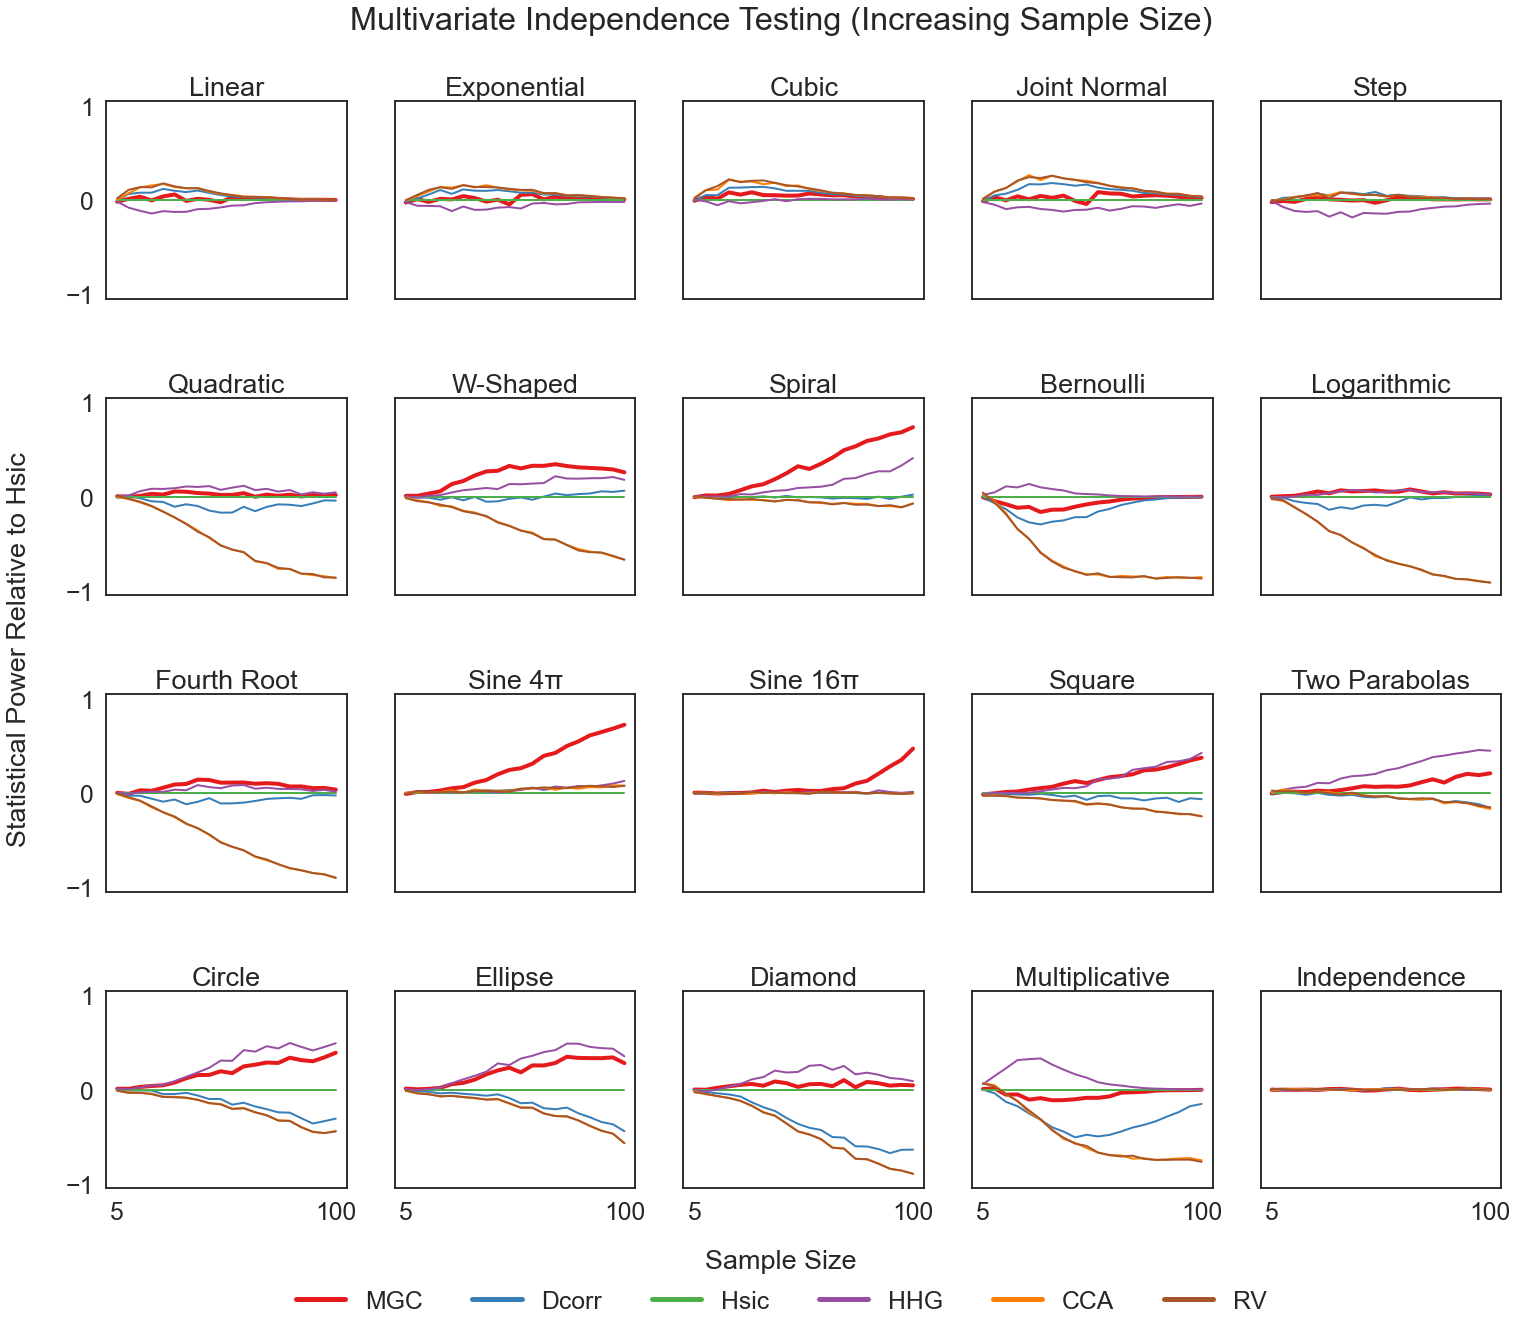

In [30]:
plot_power()